### Importing relevant libraries 

In [3]:
# ── 0) INSTALL (once, in your env) ─────────────────────────────────────────────
%pip install -U earthengine-api geemap
%pip install geopandas shapely pyproj pyogrio pyrosm osmnx tqdm requests ipywidgets "folium>=0.12" matplotlib mapclassify 

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [23]:
# ── 1) IMPORTS & SETTINGS ─────────────────────────────────────────────────────
from pathlib import Path
from typing import Optional
import requests
from datetime import datetime
import os
import time
from datetime import timedelta
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import mapclassify
import folium

import os

import ee, geemap, sys

import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon, MultiPolygon, GeometryCollection, box, shape
from shapely.ops import unary_union
from tqdm.auto import tqdm

# (Optional) pick a stable Python (3.11 or 3.12) for best wheel coverage on Windows.


# ── 2) LOAD YOUR AOI ──────────────────────────────────────────────────────────
# If you already have an AOI polygon, set aoi_poly = <your polygon in EPSG:4326>.
# Otherwise, you can geocode Colombia with OSMnx:
import osmnx as ox
ox.settings.use_cache = True
ox.settings.retry_on_rate_limit = True
# ── 6) Read with pyrosm using your AOI as bounding box ────────────────────────
from pyrosm import OSM

# Downloading & processing yearly OpenStreetMap snapshots (2017–present)

This section downloads **yearly** Colombia snapshots from Geofabrik (Jan 1 of each year) and produces one GeoPackage per year with CORINE L2 labels.

In [ ]:
# ── 3) AOI: Colombia polygon (EPSG:4326) ──────────────────────────────────────
country = ox.geocode_to_gdf("Colombia")
aoi_poly = country.geometry.iloc[0]

# Optional: create a buffer in meters around AOI to avoid edge cuts
def buffer_wgs84(poly, meters: float = 0):
    if not meters:
        return poly
    g = gpd.GeoSeries([poly], crs=4326).to_crs(3857)
    b = g.buffer(meters).to_crs(4326).iloc[0]
    return b

aoi_padded = buffer_wgs84(aoi_poly, meters=0)

# ── 4) CORINE L2 tag map (with animal_keeping added) ──────────────────────────
TAG_MAP = {
    "1.1 Urban Fabric": {
        "landuse": ["residential", "garages"],
        "building": ["garages"],
    },
    "1.2 Industrial, commercial and transport units": {
        "landuse": ["industrial", "commercial", "retail", "harbour", "port"],
        "railway": True,
        "leisure": ["marina"],
        "waterway": ["lock"],
        "man_made": ["pier"],
    },
    "1.3 Mine, dump and construction sites": {
        "landuse": ["quarry", "construction", "landfill", "brownfield"],
    },
    "1.4 Artificial, non-agricultural vegetated areas": {
        "leisure": [
            "stadium", "recreation_ground", "golf_course", "playground",
            "pitch", "park", "track", "racetrack", "sports_centre"
        ],
        "landuse": ["village_green", "allotments", "cemetery", "garden"],
        "tourism": ["zoo"],
    },
    "2.1 Arable Land": {
        "landuse": ["farmland", "farm", "farmyard", "greenhouse_horticulture"],
        "building": ["greenhouse"],
    },
    "2.2 Permanent Crops": {
        "landuse": ["vineyard", "orchard"],
    },
    "2.3 Pastures (incl. animal keeping)": {
        "landuse": ["meadow", "animal_keeping"],
    },
    "3.1 Forests": {
        "landuse": ["forest"],
        "natural": ["wood"],
    },
    "3.2 Shrub/herbaceous vegetation": {
        "natural": ["grass", "grassland", "scrub", "heath"],
        "landuse": ["grass"],
    },
    "3.3 Open spaces with little/no vegetation": {
        "natural": ["cliff", "fell", "sand", "scree", "beach", "mud", "glacier", "rock"],
    },
    "4.1 Inland wetlands": {
        "natural": ["wetland"],
        "wetland": ["marsh"],
    },
    "4.2 Coastal wetlands": {
        "natural": ["wetland"],
        "wetland": ["saltmarsh", "tidalflat"],
        "landuse": ["salt_pond"],
    },
    "5 Water bodies": {
        "natural": ["water"],
        "water": ["river", "reservoir", "pond", "basin", "dock", "canal"],
        "waterway": ["riverbank", "canal", "dock"],
    },
}

# ── 5) Build a single “SUPER” filter (union across keys/values) ───────────────
def build_super_filter(tag_map: dict) -> dict:
    SUPER = defaultdict(set)
    any_true = set()
    for d in tag_map.values():
        for k, v in d.items():
            if v is True:
                any_true.add(k)
            else:
                SUPER[k].update(v if isinstance(v, (list, set, tuple)) else [v])
    out = {k: sorted(v) for k, v in SUPER.items()}
    for k in any_true:
        out[k] = True
    return out

SUPER = build_super_filter(TAG_MAP)

# ── 6) Download yearly Geofabrik snapshots (2017–present) with correct progress ──
# By default we use Jan 1 snapshots ("0101"), which Geofabrik keeps for all years.
# If your panel uses a different within-year observation date (e.g., Nov 12 → "1112"),
# set PREFERRED_MMDD accordingly. The code will fall back to "0101" if that exact date
# is not available for an older year.
REGION_PATH = "south-america"      # Geofabrik folder
COUNTRY_SLUG = "colombia"          # Geofabrik file prefix
PREFERRED_MMDD = "0101"            # change to e.g. "1112" if needed
FALLBACK_MMDD = "0101"             # do not change unless you know you want a different fallback
START_YEAR = 2017
END_YEAR = datetime.now().year     # change if you want to stop earlier/later

DOWNLOAD_DIR = Path("../data/OSM/OSM_data") / "pbf_snapshots"
DOWNLOAD_DIR.mkdir(parents=True, exist_ok=True)

OUT_DIR = Path("../data/OSM/OSM_data") / "corine_l2_yearly"
OUT_DIR.mkdir(parents=True, exist_ok=True)

def geofabrik_url(year: int, mmdd: str) -> str:
    y2 = str(year)[-2:]
    return f"https://download.geofabrik.de/{REGION_PATH}/{COUNTRY_SLUG}-{y2}{mmdd}.osm.pbf"

def url_head(url: str, timeout: int = 30):
    """
    Returns: (ok: bool, size_bytes: Optional[int])
    """
    try:
        r = requests.head(url, allow_redirects=True, timeout=timeout)
        if r.status_code != 200:
            return False, None
        cl = r.headers.get("Content-Length")
        return True, (int(cl) if cl is not None else None)
    except Exception:
        return False, None

def pick_snapshot_for_year(year: int):
    """
    Prefer PREFERRED_MMDD (e.g. "1112"), but fall back to "0101" if not available.
    Returns: (url, mmdd, size_bytes)
    """
    for mmdd in [PREFERRED_MMDD, FALLBACK_MMDD]:
        url = geofabrik_url(year, mmdd)
        ok, sz = url_head(url)
        if ok:
            return url, mmdd, sz
    raise FileNotFoundError(f"No snapshot found for year={year} using mmdd in {[PREFERRED_MMDD, FALLBACK_MMDD]}")

def download_with_progress(url: str, dst: Path, *, force: bool = False, session: Optional[requests.Session] = None, total_pbar=None):
    """
    Stream-download with a byte-accurate progress bar (uses Content-Length).
    Writes to *.part first, then moves into place.
    """
    if dst.exists() and not force:
        return

    dst.parent.mkdir(parents=True, exist_ok=True)
    tmp = dst.with_suffix(dst.suffix + ".part")

    s = session or requests.Session()
    with s.get(url, stream=True) as r:
        r.raise_for_status()
        total = r.headers.get("Content-Length")
        total = int(total) if total else None

        with tqdm(
            total=total,
            unit="B",
            unit_scale=True,
            unit_divisor=1024,
            desc=f"Downloading {dst.name}",
            leave=False,
        ) as file_pbar, open(tmp, "wb") as f:
            for chunk in r.iter_content(chunk_size=1024 * 1024):
                if not chunk:
                    continue
                f.write(chunk)
                file_pbar.update(len(chunk))
                if total_pbar is not None:
                    total_pbar.update(len(chunk))

    tmp.replace(dst)

years = list(range(START_YEAR, END_YEAR + 1))

snapshots = {}
for y in years:
    url, mmdd, sz = pick_snapshot_for_year(y)
    snapshots[y] = {"url": url, "mmdd": mmdd, "size": sz}

known_sizes = [v["size"] for v in snapshots.values() if isinstance(v["size"], int)]
total_bytes = int(sum(known_sizes)) if known_sizes else None

print("Planned years:", years)
print("Preferred MMDD:", PREFERRED_MMDD, "Fallback MMDD:", FALLBACK_MMDD)
if total_bytes:
    print(f"Total download size (approx): {total_bytes/1024/1024:.1f} MB")

# Global progress bar across ALL downloads (gives a stable ETA)
total_bar = tqdm(
    total=total_bytes,
    unit="B",
    unit_scale=True,
    unit_divisor=1024,
    desc="Downloading snapshots (total)",
)

with requests.Session() as sess:
    for y in years:
        mmdd = snapshots[y]["mmdd"]
        dst = DOWNLOAD_DIR / f"{COUNTRY_SLUG}-{str(y)[-2:]}{mmdd}.osm.pbf"
        download_with_progress(snapshots[y]["url"], dst, force=False, session=sess, total_pbar=total_bar)

total_bar.close()
print("All snapshot downloads present in:", DOWNLOAD_DIR)

# ── 7) Process each year with pyrosm + classify into CORINE L2 ─────────────────
def norm_val(x):
    return str(x).lower() if pd.notna(x) else x

def assign_corine(row) -> Optional[str]:
    for corine, rules in TAG_MAP.items():
        for k, vals in rules.items():
            if k not in row:
                continue
            val = row[k]
            if vals is True:
                if pd.notna(val):
                    return corine
            else:
                if pd.notna(val) and any(val == str(v).lower() for v in vals):
                    return corine
    return None

summary_rows = []

for y in tqdm(years, desc="Processing yearly snapshots"):
    mmdd = snapshots[y]["mmdd"]
    pbf_path = DOWNLOAD_DIR / f"{COUNTRY_SLUG}-{str(y)[-2:]}{mmdd}.osm.pbf"
    if not pbf_path.exists():
        print(f"[WARN] Missing PBF for {y} at {pbf_path}. Skipping.")
        continue

    t0 = time.perf_counter()
    osm = OSM(str(pbf_path), bounding_box=aoi_padded)

    g_all = osm.get_data_by_custom_criteria(
        custom_filter=SUPER,
        filter_type="keep",
        osm_keys_to_keep=list(SUPER.keys()),
        keep_nodes=False,
    )

    # Ensure columns exist for safe checks
    for k in SUPER.keys():
        if k not in g_all.columns:
            g_all[k] = pd.NA

    # Normalize strings for comparisons
    for k, v in SUPER.items():
        if v is True:
            continue
        if k in g_all.columns:
            g_all[k] = g_all[k].apply(norm_val)

    tqdm.pandas(desc=f"Classifying {y}", leave=False)
    g_all["corine_l2"] = g_all.progress_apply(assign_corine, axis=1)

    out_gdf = g_all[g_all["corine_l2"].notna()].copy()
    out_gdf = out_gdf[out_gdf.geometry.notna() & ~out_gdf.geometry.is_empty]
    out_gdf = gpd.GeoDataFrame(out_gdf, geometry="geometry", crs="EPSG:4326")
    out_gdf["year"] = y

    # Write one GeoPackage per year (easy reruns, no layer conflicts)
    out_fp = OUT_DIR / f"{COUNTRY_SLUG}_corine_l2_{y}.gpkg"
    if out_fp.exists():
        out_fp.unlink()

    out_gdf.to_file(out_fp, layer="corine_l2_osm", driver="GPKG")
    dt = timedelta(seconds=int(time.perf_counter() - t0))

    summary_rows.append({
        "year": y,
        "snapshot_mmdd": mmdd,
        "features": len(out_gdf),
        "time": str(dt),
        "file": str(out_fp),
    })
    print(f"[{y} ({mmdd})] saved {len(out_gdf):,} features → {out_fp}  (time: {dt})")

summary = pd.DataFrame(summary_rows)
summary

Planned years: [2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026]
Preferred MMDD: 0101 Fallback MMDD: 0101
Total download size (approx): 1892.5 MB


All snapshot downloads present in: OSM_data\pbf_snapshots


Processing yearly snapshots:   0%|          | 0/10 [00:00<?, ?it/s]

c:\Users\cpedr\anaconda3\envs\ml\Lib\site-packages\pyrosm\pyrosm.py:109: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment.
Such chained assignment never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy (due to Copy-on-Write).

Try using '.loc[row_indexer, col_indexer] = value' instead, to perform the assignment in a single step.

See the documentation for a more detailed explanation: https://pandas.pydata.org/pandas-docs/stable/user_guide/copy_on_write.html#chained-assignment
  nodes, ways, relations, node_coordinates = parse_osm_data(
c:\Users\cpedr\anaconda3\envs\ml\Lib\site-packages\pyrosm\pyrosm.py:109: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment.
Such chained assignment never works to update the original DataFrame or Series, because the intermediate object on which we are se

Classifying 2017:   0%|          | 0/70644 [00:00<?, ?it/s]

[2017 (0101)] saved 70,363 features → OSM_data\corine_l2_yearly\colombia_corine_l2_2017.gpkg  (time: 0:07:00)


c:\Users\cpedr\anaconda3\envs\ml\Lib\site-packages\pyrosm\pyrosm.py:109: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment.
Such chained assignment never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy (due to Copy-on-Write).

Try using '.loc[row_indexer, col_indexer] = value' instead, to perform the assignment in a single step.

See the documentation for a more detailed explanation: https://pandas.pydata.org/pandas-docs/stable/user_guide/copy_on_write.html#chained-assignment
  nodes, ways, relations, node_coordinates = parse_osm_data(
c:\Users\cpedr\anaconda3\envs\ml\Lib\site-packages\pyrosm\pyrosm.py:109: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment.
Such chained assignment never works to update the original DataFrame or Series, because the intermediate object on which we are se

Classifying 2018:   0%|          | 0/88092 [00:00<?, ?it/s]

[2018 (0101)] saved 87,683 features → OSM_data\corine_l2_yearly\colombia_corine_l2_2018.gpkg  (time: 0:13:36)


c:\Users\cpedr\anaconda3\envs\ml\Lib\site-packages\pyrosm\pyrosm.py:109: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment.
Such chained assignment never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy (due to Copy-on-Write).

Try using '.loc[row_indexer, col_indexer] = value' instead, to perform the assignment in a single step.

See the documentation for a more detailed explanation: https://pandas.pydata.org/pandas-docs/stable/user_guide/copy_on_write.html#chained-assignment
  nodes, ways, relations, node_coordinates = parse_osm_data(
c:\Users\cpedr\anaconda3\envs\ml\Lib\site-packages\pyrosm\pyrosm.py:109: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment.
Such chained assignment never works to update the original DataFrame or Series, because the intermediate object on which we are se

Classifying 2019:   0%|          | 0/105203 [00:00<?, ?it/s]

[2019 (0101)] saved 104,707 features → OSM_data\corine_l2_yearly\colombia_corine_l2_2019.gpkg  (time: 0:24:18)


c:\Users\cpedr\anaconda3\envs\ml\Lib\site-packages\pyrosm\pyrosm.py:109: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment.
Such chained assignment never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy (due to Copy-on-Write).

Try using '.loc[row_indexer, col_indexer] = value' instead, to perform the assignment in a single step.

See the documentation for a more detailed explanation: https://pandas.pydata.org/pandas-docs/stable/user_guide/copy_on_write.html#chained-assignment
  nodes, ways, relations, node_coordinates = parse_osm_data(
c:\Users\cpedr\anaconda3\envs\ml\Lib\site-packages\pyrosm\pyrosm.py:109: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment.
Such chained assignment never works to update the original DataFrame or Series, because the intermediate object on which we are se

Classifying 2020:   0%|          | 0/125674 [00:00<?, ?it/s]

[2020 (0101)] saved 125,149 features → OSM_data\corine_l2_yearly\colombia_corine_l2_2020.gpkg  (time: 0:38:32)


c:\Users\cpedr\anaconda3\envs\ml\Lib\site-packages\pyrosm\pyrosm.py:109: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment.
Such chained assignment never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy (due to Copy-on-Write).

Try using '.loc[row_indexer, col_indexer] = value' instead, to perform the assignment in a single step.

See the documentation for a more detailed explanation: https://pandas.pydata.org/pandas-docs/stable/user_guide/copy_on_write.html#chained-assignment
  nodes, ways, relations, node_coordinates = parse_osm_data(
c:\Users\cpedr\anaconda3\envs\ml\Lib\site-packages\pyrosm\pyrosm.py:109: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment.
Such chained assignment never works to update the original DataFrame or Series, because the intermediate object on which we are se

Classifying 2021:   0%|          | 0/150163 [00:00<?, ?it/s]

[2021 (0101)] saved 149,329 features → OSM_data\corine_l2_yearly\colombia_corine_l2_2021.gpkg  (time: 1:09:02)


c:\Users\cpedr\anaconda3\envs\ml\Lib\site-packages\pyrosm\pyrosm.py:109: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment.
Such chained assignment never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy (due to Copy-on-Write).

Try using '.loc[row_indexer, col_indexer] = value' instead, to perform the assignment in a single step.

See the documentation for a more detailed explanation: https://pandas.pydata.org/pandas-docs/stable/user_guide/copy_on_write.html#chained-assignment
  nodes, ways, relations, node_coordinates = parse_osm_data(
c:\Users\cpedr\anaconda3\envs\ml\Lib\site-packages\pyrosm\pyrosm.py:109: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment.
Such chained assignment never works to update the original DataFrame or Series, because the intermediate object on which we are se

Classifying 2022:   0%|          | 0/173186 [00:00<?, ?it/s]

[2022 (0101)] saved 172,297 features → OSM_data\corine_l2_yearly\colombia_corine_l2_2022.gpkg  (time: 1:47:42)


c:\Users\cpedr\anaconda3\envs\ml\Lib\site-packages\pyrosm\pyrosm.py:109: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment.
Such chained assignment never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy (due to Copy-on-Write).

Try using '.loc[row_indexer, col_indexer] = value' instead, to perform the assignment in a single step.

See the documentation for a more detailed explanation: https://pandas.pydata.org/pandas-docs/stable/user_guide/copy_on_write.html#chained-assignment
  nodes, ways, relations, node_coordinates = parse_osm_data(
c:\Users\cpedr\anaconda3\envs\ml\Lib\site-packages\pyrosm\pyrosm.py:109: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment.
Such chained assignment never works to update the original DataFrame or Series, because the intermediate object on which we are se

Classifying 2023:   0%|          | 0/183295 [00:00<?, ?it/s]

[2023 (0101)] saved 182,284 features → OSM_data\corine_l2_yearly\colombia_corine_l2_2023.gpkg  (time: 2:50:24)


c:\Users\cpedr\anaconda3\envs\ml\Lib\site-packages\pyrosm\pyrosm.py:109: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment.
Such chained assignment never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy (due to Copy-on-Write).

Try using '.loc[row_indexer, col_indexer] = value' instead, to perform the assignment in a single step.

See the documentation for a more detailed explanation: https://pandas.pydata.org/pandas-docs/stable/user_guide/copy_on_write.html#chained-assignment
  nodes, ways, relations, node_coordinates = parse_osm_data(
c:\Users\cpedr\anaconda3\envs\ml\Lib\site-packages\pyrosm\pyrosm.py:109: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment.
Such chained assignment never works to update the original DataFrame or Series, because the intermediate object on which we are se

Classifying 2024:   0%|          | 0/193690 [00:00<?, ?it/s]

[2024 (0101)] saved 192,600 features → OSM_data\corine_l2_yearly\colombia_corine_l2_2024.gpkg  (time: 3:22:20)


c:\Users\cpedr\anaconda3\envs\ml\Lib\site-packages\pyrosm\pyrosm.py:109: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment.
Such chained assignment never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy (due to Copy-on-Write).

Try using '.loc[row_indexer, col_indexer] = value' instead, to perform the assignment in a single step.

See the documentation for a more detailed explanation: https://pandas.pydata.org/pandas-docs/stable/user_guide/copy_on_write.html#chained-assignment
  nodes, ways, relations, node_coordinates = parse_osm_data(
c:\Users\cpedr\anaconda3\envs\ml\Lib\site-packages\pyrosm\pyrosm.py:109: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment.
Such chained assignment never works to update the original DataFrame or Series, because the intermediate object on which we are se

Classifying 2025:   0%|          | 0/211381 [00:00<?, ?it/s]

[2025 (0101)] saved 210,185 features → OSM_data\corine_l2_yearly\colombia_corine_l2_2025.gpkg  (time: 4:08:47)


c:\Users\cpedr\anaconda3\envs\ml\Lib\site-packages\pyrosm\pyrosm.py:109: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment.
Such chained assignment never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy (due to Copy-on-Write).

Try using '.loc[row_indexer, col_indexer] = value' instead, to perform the assignment in a single step.

See the documentation for a more detailed explanation: https://pandas.pydata.org/pandas-docs/stable/user_guide/copy_on_write.html#chained-assignment
  nodes, ways, relations, node_coordinates = parse_osm_data(
c:\Users\cpedr\anaconda3\envs\ml\Lib\site-packages\pyrosm\pyrosm.py:109: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment.
Such chained assignment never works to update the original DataFrame or Series, because the intermediate object on which we are se

Classifying 2026:   0%|          | 0/228383 [00:00<?, ?it/s]

[2026 (0101)] saved 227,184 features → OSM_data\corine_l2_yearly\colombia_corine_l2_2026.gpkg  (time: 5:21:09)


,year,snapshot_mmdd,features,time,file
0,2017,0101,70363,0:07:00,OSM_data\corine_l2_yearly\colombia_corine_l2_2...
1,2018,0101,87683,0:13:36,OSM_data\corine_l2_yearly\colombia_corine_l2_2...
2,2019,0101,104707,0:24:18,OSM_data\corine_l2_yearly\colombia_corine_l2_2...
3,2020,0101,125149,0:38:32,OSM_data\corine_l2_yearly\colombia_corine_l2_2...
4,2021,0101,149329,1:09:02,OSM_data\corine_l2_yearly\colombia_corine_l2_2...
5,2022,0101,172297,1:47:42,OSM_data\corine_l2_yearly\colombia_corine_l2_2...
6,2023,0101,182284,2:50:24,OSM_data\corine_l2_yearly\colombia_corine_l2_2...
7,2024,0101,192600,3:22:20,OSM_data\corine_l2_yearly\colombia_corine_l2_2...
8,2025,0101,210185,4:08:47,OSM_data\corine_l2_yearly\colombia_corine_l2_2...
9,2026,0101,227184,5:21:09,OSM_data\corine_l2_yearly\colombia_corine_l2_2...


# Mapping a selected year

Choose a year, load its GeoPackage, and plot / explore the CORINE L2 labels. We fetch Colombia boundaries from an Earth Engine administrative boundaries dataset and build a single geometry.

In [6]:
# --- Earth Engine authentication / initialization ---
# Colab: ee.Authenticate() will open a link + code flow
# Local Jupyter: usually ee.Initialize() works after `earthengine authenticate`

try:
    ee.Initialize()
    print("✅ Earth Engine initialized (existing credentials).")
except Exception as e:
    print("Earth Engine init failed:", e)
    print("\nRunning ee.Authenticate() ...")
    ee.Authenticate()
    ee.Initialize()
    print("✅ Earth Engine initialized (after authentication).")

✅ Earth Engine initialized (existing credentials).


In [24]:
# Colombia boundary (GAUL simplified). Alternatives: USDOS/LSIB_SIMPLE/2017, etc.
countries = ee.FeatureCollection("FAO/GAUL_SIMPLIFIED_500m/2015/level0")

colombia = countries.filter(ee.Filter.eq("ADM0_NAME", "Colombia")).first()
shapes = ee.Feature(colombia).geometry()

# Convert ee.Geometry -> shapely geometry
colombia_shapely = shape(shapes.getInfo())  # OK for a country boundary (not huge)
col_outline = gpd.GeoSeries([colombia_shapely], crs="EPSG:4326")

# Getting rid of Point geometries that cause plotting issues -----
# Shapely "make_valid" differs across versions
try:
    from shapely import make_valid  # shapely>=2
except Exception:
    from shapely.validation import make_valid  # older shapely

def polygons_from_any(geom):
    """Extract Polygon parts from Polygon/MultiPolygon/GeometryCollection."""
    polys = []
    if geom is None or geom.is_empty:
        return polys

    gt = geom.geom_type
    if gt == "Polygon":
        polys = [geom]
    elif gt == "MultiPolygon":
        polys = list(geom.geoms)
    elif gt == "GeometryCollection":
        for g in geom.geoms:
            if g.geom_type == "Polygon":
                polys.append(g)
            elif g.geom_type == "MultiPolygon":
                polys.extend(list(g.geoms))
    else:
        # ignore LineString/Point etc.
        polys = []

    return polys

def safe_valid(geom):
    """Make geometry valid; fallback to buffer(0) for polygons if needed."""
    if geom is None:
        return geom
    if geom.is_empty:
        return geom
    try:
        return make_valid(geom)
    except Exception:
        if geom.geom_type in ("Polygon", "MultiPolygon"):
            try:
                return geom.buffer(0)
            except Exception:
                return geom
        return geom

# --- EE Colombia geometry (independent of your CORINE gdf) ---
countries = ee.FeatureCollection("FAO/GAUL_SIMPLIFIED_500m/2015/level0")
col_feat = countries.filter(ee.Filter.eq("ADM0_NAME", "Colombia")).first()

# ee.Geometry -> GeoJSON dict -> shapely geometry
col_geom = shape(col_feat.geometry().getInfo())
col_geom = safe_valid(col_geom)

# Extract polygon parts and build:
polys = polygons_from_any(col_geom)
if len(polys) == 0:
    raise ValueError("No polygon parts found in Colombia geometry from EE dataset.")

# dissolve all polygon parts into one outline
col_outline_geom = safe_valid(unary_union(polys))

# "mainland" = largest polygon by area (drops islands)
mainland = max(polys, key=lambda g: g.area)
mainland = safe_valid(mainland)

# GeoPandas objects you can reuse later
col_outline = gpd.GeoSeries([col_outline_geom], crs="EPSG:4326")
mainland_mask = gpd.GeoSeries([mainland], crs="EPSG:4326")

In [26]:
# --- choose year to map ---
YEAR_TO_VIEW = 2026  # change this

fp = Path("../data/OSM/OSM_data") / "corine_l2_yearly" / f"colombia_corine_l2_{YEAR_TO_VIEW}.gpkg"
gdf = gpd.read_file(fp, layer="corine_l2_osm").to_crs(4326)

# Fix invalid geometries in gdf 
gdf["geometry"] = gdf.geometry.apply(safe_valid)
gdf = gdf[gdf.geometry.notnull() & ~gdf.is_empty].copy()

# Clip to mainland (mask is a shapely Polygon)
mask_geom = mainland_mask.iloc[0]
gdf = gpd.clip(gdf, mask_geom)

gdf.head()

,basin,construction,depot,industrial,landuse,meadow,military,port,quarry,residential,...,stadium,river,station,subway,tram,changeset,man_made,corine_l2,year,geometry
56559,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,NaN,<NA>,3.1 Forests,2026,"MULTIPOLYGON (((-69.94441 -4.22293, -69.94415 ..."
211649,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,NaN,<NA>,3.3 Open spaces with little/no vegetation,2026,"POLYGON ((-69.9521 -4.22668, -69.95323 -4.2239..."
63640,None,None,None,None,industrial,None,None,None,None,None,...,None,None,None,None,None,NaN,<NA>,"1.2 Industrial, commercial and transport units",2026,"POLYGON ((-69.94298 -4.22415, -69.94215 -4.223..."
132780,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,NaN,<NA>,"1.4 Artificial, non-agricultural vegetated areas",2026,"POLYGON ((-69.94134 -4.22297, -69.94143 -4.223..."
129764,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,NaN,<NA>,"1.4 Artificial, non-agricultural vegetated areas",2026,"POLYGON ((-69.94221 -4.21919, -69.94208 -4.219..."


C:\Users\cpedr\AppData\Local\Temp\ipykernel_16832\998819938.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", N)


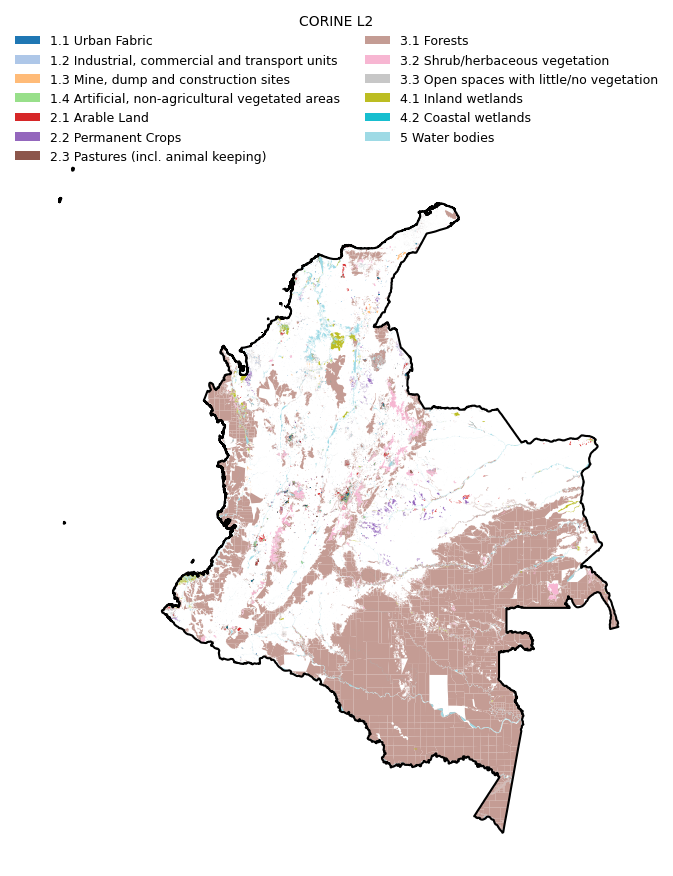

In [29]:
# if shapes contains many polygons (e.g. municipalities/departments),
# dissolve to get a single Colombia outline:
# col_outline = shapes.dissolve()      # 1 row, full country geometry

# --- unique color per CORINE class ---
classes = sorted(gdf["corine_l2"].unique())
N = len(classes)

cmap = plt.cm.get_cmap("tab20", N)
colors = [cmap(i) for i in range(N)]
color_map = dict(zip(classes, colors))

# --- plot ---
fig, ax = plt.subplots(figsize=(8, 10))

for cls, data in gdf.groupby("corine_l2"):
    data.plot(
        ax=ax,
        color=color_map[cls],
        edgecolor="none",
        linewidth=0,
    )

# Draw Colombia outline on top
col_outline.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=1.5, zorder=10)

# --- legend with colored patches ---
handles = [
    Patch(facecolor=color_map[cls], edgecolor="none", label=cls)
    for cls in classes
]

# --- legend ---
leg = ax.legend(
    handles=handles,
    title="CORINE L2",
    loc="upper center",
    bbox_to_anchor=(0.5, 1.18),  # higher = more space above map
    ncol=2,
    frameon=False,
    fontsize=9,
    title_fontsize=10,
)

# Reserve space at the top for the legend 
ax.set_axis_off()
fig.subplots_adjust(top=1)   # smaller top => more room for legend
plt.show()

In [32]:
# --- ensure CRS and remove point geometries (prevents big dot markers) ---
gdf = gdf.to_crs("EPSG:4326")
gdf = gdf[gdf.geom_type.isin(["Polygon", "MultiPolygon"])].copy()

# If you have NOT clipped earlier, uncomment this:
# mask_geom = mainland_mask.iloc[0]
# gdf = gpd.clip(gdf, mask_geom)

# ---- make a LIGHT version of the LULC ----
g_light = gdf[["corine_l2", "geometry"]].copy()

# simplify geometries in meters
g_light_3857 = g_light.to_crs(3857)
g_light_3857["geometry"] = g_light_3857.geometry.simplify(
    2000,  # tolerance ~2 km
    preserve_topology=False
)
g_light = g_light_3857.to_crs(4326)
g_light = g_light[g_light.geometry.notna() & ~g_light.geometry.is_empty].copy()

# ---- LIGHT boundary layer (from EE-derived mainland mask / outline) ----
# Use mainland outline to avoid islands; switch to col_outline if you want all islands too.
admin_gdf = gpd.GeoDataFrame(
    {"name": ["Colombia (mainland)"]},
    geometry=mainland_mask,   # <- use col_outline here if you want islands included
    crs="EPSG:4326"
)

admin_3857 = admin_gdf.to_crs(3857)
admin_3857["geometry"] = admin_3857.geometry.simplify(5000, preserve_topology=False)
admin_gdf = admin_3857.to_crs(4326)
admin_gdf = admin_gdf[admin_gdf.geometry.notna() & ~admin_gdf.geometry.is_empty].copy()

# ---- stable categorical colormap ----
classes = sorted(g_light["corine_l2"].unique())
N = len(classes)
cmap = plt.cm.get_cmap("tab20", N)
colors = [cmap(i) for i in range(N)]

# 1) base map: light LULC polygons
m = g_light.explore(
    column="corine_l2",
    tiles="CartoDB positron",
    tooltip=["corine_l2"],
    popup=False,
    cmap=ListedColormap(colors),
    name="CORINE L2 (light)",
)

# 2) add simplified mainland boundary on top (as line)
admin_gdf.boundary.explore(
    m=m,
    color="black",
    style_kwds={"weight": 2, "opacity": 0.8},
    name="Colombia boundary (mainland)",
)

# optional: layer control
import folium
folium.LayerControl(collapsed=False).add_to(m)

m

# optional: save to html
out_html = Path("../data/OSM") / f"colombia_corine_light_interactive_{YEAR_TO_VIEW}.html"
m.save(out_html)
print("Saved:", out_html)

C:\Users\cpedr\AppData\Local\Temp\ipykernel_16832\1939489503.py:19: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  g_light = g_light[g_light.geometry.notna() & ~g_light.geometry.is_empty].copy()
C:\Users\cpedr\AppData\Local\Temp\ipykernel_16832\1939489503.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", N)


Saved: ..\data\OSM\colombia_corine_light_interactive_2026.html
